In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from netrep.metrics import LinearMetric

#TODO: increase the temperature value
model = AutoModelForCausalLM.from_pretrained('/Users/joshstallings/Desktop/LipshutzLab/TinyStories-1M') 
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
model.eval()

# Define the hook function
def get_activation(name):
    def hook(model, input, output):
        # We save the output of the layer
        saved_activations[name] = output
    return hook


/opt/anaconda3/envs/lipshutz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROMPT = "Once upon a time there was"
NUM_EXPERIMENTS = 10
ACTIVATION_RESPONSES = []
RESPONSES = []

In [ ]:
# Get the last layer of the model
last_layer = model.transformer.h[-1]

# Register hook function to the model's forward pass on the last layer
last_layer.register_forward_hook(get_activation('last_layer_output'))

# Custom Generation loop. 
# TODO: is there a more sophisticated way to write my own generation loops?
# TODO: is this even a correct generation loop? 
for i in range(NUM_EXPERIMENTS):
    # Tokenize the input. 
    input_ids = tokenizer(PROMPT, return_tensors="pt").input_ids
    current_ids = input_ids
    saved_activations = {}
    for _ in range(10): # Generate 10 new tokens
        # Model forward pass. The hook will be triggered here.
        with torch.no_grad():
            outputs = model(current_ids)
        
        # Get the logits for the next token
        # Logits are values before they are passed to the activation function.
        logits = outputs.logits
        next_token_logits = logits[:, -1, :]
        
        # Select the next token with greedy decoding
        # TODO: randomly pick a token. 
        # softmax function
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # Append the new token to the sequence
        current_ids = torch.cat([current_ids, next_token_id], dim=-1)
        

    # Process the responses. I want to be notified if something doesn't meet a certain shape. 
    activation_response = saved_activations['last_layer_output']
    if(len(activation_response) != 2 and len(activation_response[0]) != 1):
        print(f"Unexpected shape in activation_response: ({len(activation_response)}, {len(activation_response[0])})")
        continue
    elif(activation_response[0][0].shape != (15, 64) or activation_response[1][0].shape != (16, 15, 15)):
        print(f"Unexpected shape in tensor: {activation_response[0][0].shape}, {activation_response[1][0].shape}")
        continue
    else:
        ACTIVATION_RESPONSES.append(activation_response)
        RESPONSES.append(current_ids[0])

In [ ]:
# response tuple shape = (2, 1)
# tensor shape = (15, 64) and (16, 15, 15)
# some of them are already numpy arrays?
tensor_1s = []
tensor_2s = []
print(len(ACTIVATION_RESPONSES))

# Convert the responses to numpy arrays. 
for activation_response in ACTIVATION_RESPONSES:
    tensor_1 = None
    tensor_2 = None
    try:
        tensor_1 = activation_response[0][0].numpy()
    except:
        tensor_1 = activation_response[0][0].shape
    try:
        tensor_2 = activation_response[1][0].numpy()
    except:
        tensor_2 = activation_response[1][0].shape
    
    tensor_1s.append(tensor_1)
    tensor_2s.append(tensor_2)


10


In [12]:
# alpha = 0  => linearly invariant, like CCA
# alpha = 1 => rotationally invariant, only rotational alignments. 
metric = LinearMetric(alpha=1)
dist_matrix_1, _ = metric.pairwise_distances(tensor_1s, verbose=False)
# dist_matrix_2, _  = metric.pairwise_distances(tensor_2s)  # these aren't 2d arrays need to figure that out


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

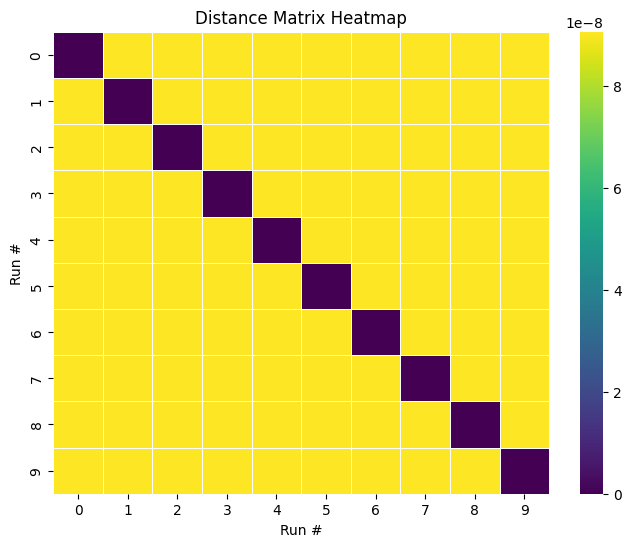

Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
Once upon a time there was a little girl named Lily. She loved to play
[[0.0000000e+00 9.0640225e-08 9.0640225e-08 9.0640225e-08 9.0640225e-08
  9.0640225e-08 9.0640225e-08 9.0640225e-08 9.0640225e-08 9.0640225e-08]
 [9.0640225e-08 0.0000000e+00 9.0640225e-08 9.0640225e-08 9.0640225e-08
  9.0640225e-08 9.0640225e-08 9.0640225e-08 9.0640225e-08 9.0640225e-08]


In [14]:
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(dist_matrix_1, cmap='viridis', annot=False, fmt=".2f", linewidths=.5)

plt.title('Distance Matrix Heatmap')
plt.xlabel('Run #')
plt.ylabel('Run #')
plt.show()

for response in RESPONSES:
    print(tokenizer.decode(response))

print(dist_matrix_1)